<a href="https://colab.research.google.com/github/rahulmk8055/AI-vs-Human-Text-Classification/blob/main/classical_machinelearning_inferenceimplemeted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Machine Learning Model Training Steps

1. **Train the Logistic Regression Model**
2. **Train the Logistic Regression Model with Grid Search**
3. **Train the Logistic Regression Model with Randomized Search**
4. **Train the SVM Model**

Below, I have implemented different types of machine learning models. If you make any changes to the dataset, ensure that `X` and `y` are correctly implemented.


<a href="https://colab.research.google.com/github/rahulmk8055/AI-vs-Human-Text-Classification/blob/main/Preprocessing_word2vec_features_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Loading**

In [1]:
!pip -q install transformers==4.31.0 datasets tqdm

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset

ds = load_dataset("Hello-SimpleAI/HC3", "all")

In [3]:
train_dataset = ds['train']
train_df = train_dataset.to_pandas()
print(train_df.head())

  id                                           question  \
0  0  Why is every book I hear about a " NY Times # ...   
1  1  If salt is so bad for cars , why do we use it ...   
2  2  Why do we still have SD TV channels when HD lo...   
3  3  Why has nobody assassinated Kim Jong - un He i...   
4  4  How was airplane technology able to advance so...   

                                       human_answers  \
0  [Basically there are many categories of " Best...   
1  [salt is good for not dying in car crashes and...   
2  [The way it works is that old TV stations got ...   
3  [You ca n't just go around assassinating the l...   
4  [Wanting to kill the shit out of Germans drive...   

                                     chatgpt_answers       source  
0  [There are many different best seller lists th...  reddit_eli5  
1  [Salt is used on roads to help melt ice and sn...  reddit_eli5  
2  [There are a few reasons why we still have SD ...  reddit_eli5  
3  [It is generally not acceptable o

In [4]:
human_df = train_df[['id', 'human_answers']].rename(columns={'id': 'prompt_id', 'human_answers': 'gen_text'})

chatgpt_df = train_df[['id', 'chatgpt_answers']].rename(columns={'id': 'prompt_id', 'chatgpt_answers': 'gen_text'})

In [5]:
import pandas as pd

human_df['label'] = pd.Series(0, index=human_df.index)
chatgpt_df['label'] = pd.Series(1, index=chatgpt_df.index)

In [6]:

final_df = pd.concat([human_df, chatgpt_df], axis=0)
final_df = final_df.reset_index(drop=True)  # Reset index and drop the old one
print(final_df)

      prompt_id                                           gen_text  label
0             0  [Basically there are many categories of " Best...      0
1             1  [salt is good for not dying in car crashes and...      0
2             2  [The way it works is that old TV stations got ...      0
3             3  [You ca n't just go around assassinating the l...      0
4             4  [Wanting to kill the shit out of Germans drive...      0
...         ...                                                ...    ...
48639     24317  [It's not uncommon for blood pressure to fluct...      1
48640     24318  [There are several possible causes of a painle...      1
48641     24319  [It is not appropriate for me to recommend a s...      1
48642     24320  [It is not uncommon for people with rheumatoid...      1
48643     24321  [It is not uncommon to experience back pain, e...      1

[48644 rows x 3 columns]


In [7]:
def join_all_items(text_list):
    return ' '.join(text_list)  # Join all items into a single string

final_df['text'] = final_df['gen_text'].apply(join_all_items)

print(final_df[['gen_text', 'text']])

                                                gen_text  \
0      [Basically there are many categories of " Best...   
1      [salt is good for not dying in car crashes and...   
2      [The way it works is that old TV stations got ...   
3      [You ca n't just go around assassinating the l...   
4      [Wanting to kill the shit out of Germans drive...   
...                                                  ...   
48639  [It's not uncommon for blood pressure to fluct...   
48640  [There are several possible causes of a painle...   
48641  [It is not appropriate for me to recommend a s...   
48642  [It is not uncommon for people with rheumatoid...   
48643  [It is not uncommon to experience back pain, e...   

                                                    text  
0      Basically there are many categories of " Best ...  
1      salt is good for not dying in car crashes and ...  
2      The way it works is that old TV stations got a...  
3      You ca n't just go around assassinat

In [8]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48644 entries, 0 to 48643
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   prompt_id  48644 non-null  object
 1   gen_text   48644 non-null  object
 2   label      48644 non-null  int64 
 3   text       48644 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


# **Data pre-processing**

## **Remove duplicates**

In [9]:
##dropping duplicates and keeping first records
unique_df = final_df.drop_duplicates(subset=['text'], keep='first')

## **Lowercasing**

In [10]:
def to_lowercase(text):
    if isinstance(text, str):
        return text.lower()
    elif isinstance(text, (list, tuple)):
        return ' '.join([to_lowercase(elem) for elem in text])
    else:
        return text

unique_df['text'] = unique_df['text'].apply(to_lowercase)

<ipython-input-10-a21240a32eae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['text'] = unique_df['text'].apply(to_lowercase)


## **Removing Regex**

In [11]:
import re

def remove_punctuation(text):
    # Replace all non-alphanumeric characters with an empty string
    return re.sub(r'[^\w\s]', '', text) if type(text) == str else text

unique_df['text'] = unique_df['text'].apply(remove_punctuation)

<ipython-input-11-2922ddf5de1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['text'] = unique_df['text'].apply(remove_punctuation)


In [12]:
unique_df.tail()

,prompt_id,gen_text,label,text
48639,24317,[It's not uncommon for blood pressure to fluct...,1,its not uncommon for blood pressure to fluctua...
48640,24318,[There are several possible causes of a painle...,1,there are several possible causes of a painles...
48641,24319,[It is not appropriate for me to recommend a s...,1,it is not appropriate for me to recommend a sp...
48642,24320,[It is not uncommon for people with rheumatoid...,1,it is not uncommon for people with rheumatoid ...
48643,24321,"[It is not uncommon to experience back pain, e...",1,it is not uncommon to experience back pain esp...


## **Data joining with Perplexity scores**

### **Perplexity Scores calculating method**

In [13]:
# import torch
# from tqdm.auto import tqdm
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# model = GPT2LMHeadModel.from_pretrained('gpt2')
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# def calculate_perplexity(text, tokenizer, model, stride=512, max_length=1024):
#     # Ensure the text is truncated to the maximum model length
#     encodings = tokenizer(text[:max_length], return_tensors='pt')

#     nlls = []
#     for i in range(0, encodings.input_ids.size(1), stride):
#         begin_loc = max(i + stride - max_length, 0)
#         end_loc = min(i + stride, encodings.input_ids.size(1))
#         trg_len = end_loc - i
#         input_ids = encodings.input_ids[:, begin_loc:end_loc]
#         target_ids = input_ids.clone()
#         target_ids[:, :-trg_len] = -100

#         with torch.no_grad():
#             outputs = model(input_ids, labels=target_ids)
#             log_likelihood = outputs[0] * trg_len

#         nlls.append(log_likelihood)

#     ppl = torch.exp(torch.stack(nlls).sum() / encodings.input_ids.size(1))
#     return ppl.item()

# def calculate_perplexities(df, tokenizer, model):
#     # Add a new column for perplexity
#     df['Perplexity'] = 0
#     for i in tqdm(range(len(df)), desc='Calculating Perplexities'):
#         df.at[i, 'Perplexity'] = calculate_perplexity(df['text'].iloc[i], tokenizer, model)
#     return df

# # Assuming `unique_df` is your DataFrame with the texts
# #unique_df = calculate_perplexities(unique_df, tokenizer, model)


### **Loading Perplexity form file due to computational challenge**

In [14]:
prpx_df = pd.read_csv('outputDataset (1).csv')
prpx_df.head()

,text,label,prompt_id,Perplexity
0,in a restaurant llc capital improvements are e...,1,22157,44.249859
1,to make a cross post on reddit follow these st...,1,16861,17.930466
2,i used to work graveyard at a hospital 8 hr s...,0,8354,38.540791
3,murder is the deliberate intentional killing o...,0,561,49.939682
4,time travel is a concept that has been explore...,1,3943,17.315653


In [15]:
# Convert 'prompt_id' and 'label' columns to the same data type in both DataFrames
unique_df['prompt_id'] = unique_df['prompt_id'].astype(str)
unique_df['label'] = unique_df['label'].astype(int)  # or str, depending on the correct type

prpx_df['prompt_id'] = prpx_df['prompt_id'].astype(str)
prpx_df['label'] = prpx_df['label'].astype(int)  # or str, depending on the correct type

prpx_df_subset = prpx_df[['prompt_id', 'label', 'Perplexity']]

prpx_merged_df = pd.merge(unique_df, prpx_df_subset, on=['prompt_id', 'label'], how='inner')

prpx_merged_df.head()

<ipython-input-15-67a5b12eaf7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['prompt_id'] = unique_df['prompt_id'].astype(str)
<ipython-input-15-67a5b12eaf7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['label'] = unique_df['label'].astype(int)  # or str, depending on the correct type


,prompt_id,gen_text,label,text,Perplexity
0,1,[salt is good for not dying in car crashes and...,0,salt is good for not dying in car crashes and ...,44.319637
1,7,[It 's three fold : * Stuff is cheaper to mass...,0,it s three fold stuff is cheaper to mass pro...,51.422234
2,8,"[EDIT , Nov 21 : By popular demand , now inclu...",0,edit nov 21 by popular demand now includes ...,25.174006
3,9,"[Like viruses , they are ( groups of ) molecul...",0,like viruses they are groups of molecules t...,49.774681
4,12,"[Most of the time , any location wo nt do . Th...",0,most of the time any location wo nt do they ...,53.932930


In [16]:
prpx_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prompt_id   15000 non-null  object 
 1   gen_text    15000 non-null  object 
 2   label       15000 non-null  int64  
 3   text        15000 non-null  object 
 4   Perplexity  14999 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 703.1+ KB


In [17]:
prpx_merged_df = prpx_merged_df.dropna(subset=['Perplexity'])

### **Removing outlier and Perplexity plot**

In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# df1 = prpx_merged_df[prpx_merged_df['label']==0]
# df2 = prpx_merged_df[prpx_merged_df['label']==1]

# # Calculate IQR and filter out the outliers
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# df1_no_outliers = remove_outliers(df1, 'Perplexity')
# df2_no_outliers = remove_outliers(df2, 'Perplexity')

# # Create a combined DataFrame for Seaborn
# combined_no_outliers_df = pd.concat([df1_no_outliers, df2_no_outliers])

# # Map labels to the desired names
# label_mapping = {0: 'Human', 1: 'LLM'}
# combined_no_outliers_df['Text Generated by'] = combined_no_outliers_df['label'].map(label_mapping)

# # Calculate the median perplexity score after removing outliers
# median_perplexity_no_outliers = combined_no_outliers_df['Perplexity'].median()

# # Plot using Seaborn
# plt.figure(figsize=(5, 5))
# sns.boxplot(x='Text Generated by', y='Perplexity', data=combined_no_outliers_df)
# plt.axhline(median_perplexity_no_outliers, color='red', linestyle='--', label=f'Median Perplexity: {median_perplexity_no_outliers:.2f}')
# plt.title('Perplexity Score using GPT2 model for AI vs Human text (Outliers Removed)')
# plt.xlabel('Text Generated by')
# plt.ylabel('Perplexity')
# plt.legend()

# plt.show()

## **Brustiness**

In [19]:
import numpy as np
!pip -q install nltk
import nltk
nltk.download('punkt')

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt to
[nltk_data]     /home/patel.anuj2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
def calculate_burstiness(text):
    tokens = nltk.word_tokenize(text)
    if not tokens:
        return 0
    lengths = [len(token) for token in tokens]
    mean_length = np.mean(lengths)
    std_dev_length = np.std(lengths)
    burstiness = std_dev_length / mean_length if mean_length > 0 else 0
    return burstiness


prpx_merged_df.loc[:, 'Burstiness'] = prpx_merged_df['text'].apply(lambda x: calculate_burstiness(x) if isinstance(x, str) else 0)

# Display the DataFrame to check the result
prpx_merged_df.head()

,prompt_id,gen_text,label,text,Perplexity,Burstiness
0,1,[salt is good for not dying in car crashes and...,0,salt is good for not dying in car crashes and ...,44.319637,0.543227
1,7,[It 's three fold : * Stuff is cheaper to mass...,0,it s three fold stuff is cheaper to mass pro...,51.422234,0.534723
2,8,"[EDIT , Nov 21 : By popular demand , now inclu...",0,edit nov 21 by popular demand now includes ...,25.174006,0.525524
3,9,"[Like viruses , they are ( groups of ) molecul...",0,like viruses they are groups of molecules t...,49.774681,0.489071
4,12,"[Most of the time , any location wo nt do . Th...",0,most of the time any location wo nt do they ...,53.932930,0.509550


## **Readability Scores**

In [21]:
!pip -q install textstat

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import textstat

# Function to calculate readability scores
def calculate_readability_scores(text):
    scores = {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
        'difficult_words': textstat.difficult_words(text),
        'linsear_write_formula': textstat.linsear_write_formula(text),
        'gunning_fog': textstat.gunning_fog(text)
    }
    return scores

# Apply the readability scores function to the DataFrame
readability_scores = prpx_merged_df['text'].apply(calculate_readability_scores)

# Convert the scores into a DataFrame and concatenate with the original DataFrame
readability_df = readability_scores.apply(pd.Series)
prpx_merged_df = pd.concat([prpx_merged_df, readability_df], axis=1)

# Display the DataFrame
prpx_merged_df.head(2)

,prompt_id,gen_text,label,text,Perplexity,Burstiness,flesch_reading_ease,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog
0,1,[salt is good for not dying in car crashes and...,0,salt is good for not dying in car crashes and ...,44.319637,0.543227,-285.13,144.5,9.55,183.2,25.28,57.0,55.0,149.48
1,7,[It 's three fold : * Stuff is cheaper to mass...,0,it s three fold stuff is cheaper to mass pro...,51.422234,0.534723,-209.01,115.2,9.49,145.6,21.46,45.0,59.0,119.52


In [23]:
prpx_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   prompt_id                     14999 non-null  object 
 1   gen_text                      14999 non-null  object 
 2   label                         14999 non-null  int64  
 3   text                          14999 non-null  object 
 4   Perplexity                    14999 non-null  float64
 5   Burstiness                    14999 non-null  float64
 6   flesch_reading_ease           14999 non-null  float64
 7   flesch_kincaid_grade          14999 non-null  float64
 8   coleman_liau_index            14999 non-null  float64
 9   automated_readability_index   14999 non-null  float64
 10  dale_chall_readability_score  14999 non-null  float64
 11  difficult_words               14999 non-null  float64
 12  linsear_write_formula         14999 non-null  float64
 13  g

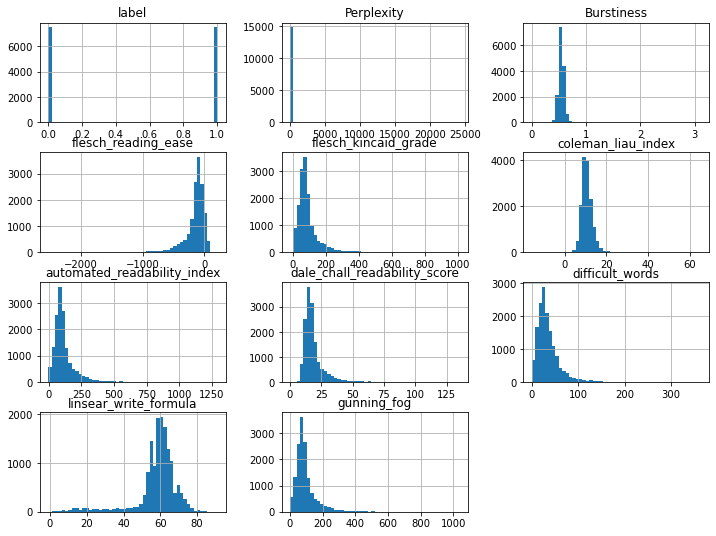

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
prpx_merged_df.hist(bins=50, figsize=(12,9))
plt.show()

In [25]:
from scipy.stats import zscore

def remove_outliers(df, columns, threshold=3):
    for column in columns:
        # Calculate the Z-scores of the column
        df['zscore'] = zscore(df[column])

        # Identify outliers
        outliers = df[(df['zscore'] > threshold) | (df['zscore'] < -threshold)]
        print(f"{column} outliers: {outliers.shape[0]} rows")

        # Drop outliers
        df = df.drop(outliers.index)

        # Drop the Z-score column
        df = df.drop(columns=['zscore'])

    return df

# Example usage:
# Assuming prpx_merged_df is your DataFrame and you want to process specific columns
columns_to_check = ['Perplexity','Burstiness','flesch_reading_ease','flesch_kincaid_grade','coleman_liau_index','automated_readability_index','dale_chall_readability_score','difficult_words','linsear_write_formula','gunning_fog']
cleaned_df = remove_outliers(prpx_merged_df, columns_to_check)

Perplexity outliers: 51 rows
Burstiness outliers: 122 rows
flesch_reading_ease outliers: 300 rows
flesch_kincaid_grade outliers: 288 rows
coleman_liau_index outliers: 133 rows
automated_readability_index outliers: 220 rows
dale_chall_readability_score outliers: 168 rows
difficult_words outliers: 112 rows
linsear_write_formula outliers: 477 rows
gunning_fog outliers: 157 rows


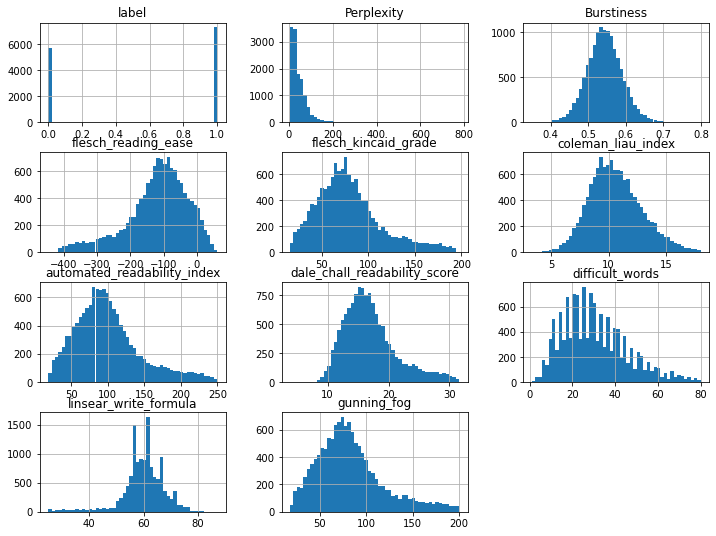

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
cleaned_df.hist(bins=50, figsize=(12,9))
plt.show()

In [27]:
cleaned_df.shape

(12971, 14)

In [28]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12971 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   prompt_id                     12971 non-null  object 
 1   gen_text                      12971 non-null  object 
 2   label                         12971 non-null  int64  
 3   text                          12971 non-null  object 
 4   Perplexity                    12971 non-null  float64
 5   Burstiness                    12971 non-null  float64
 6   flesch_reading_ease           12971 non-null  float64
 7   flesch_kincaid_grade          12971 non-null  float64
 8   coleman_liau_index            12971 non-null  float64
 9   automated_readability_index   12971 non-null  float64
 10  dale_chall_readability_score  12971 non-null  float64
 11  difficult_words               12971 non-null  float64
 12  linsear_write_formula         12971 non-null  float64
 13  g

## **Most collinear vectors**

Correlation Matrix:
label                           1.000000
linsear_write_formula           0.301499
coleman_liau_index              0.266148
flesch_reading_ease             0.111302
Burstiness                      0.031308
difficult_words                -0.098589
flesch_kincaid_grade           -0.130470
automated_readability_index    -0.130478
gunning_fog                    -0.140056
dale_chall_readability_score   -0.209213
Perplexity                     -0.597042
Name: label, dtype: float64


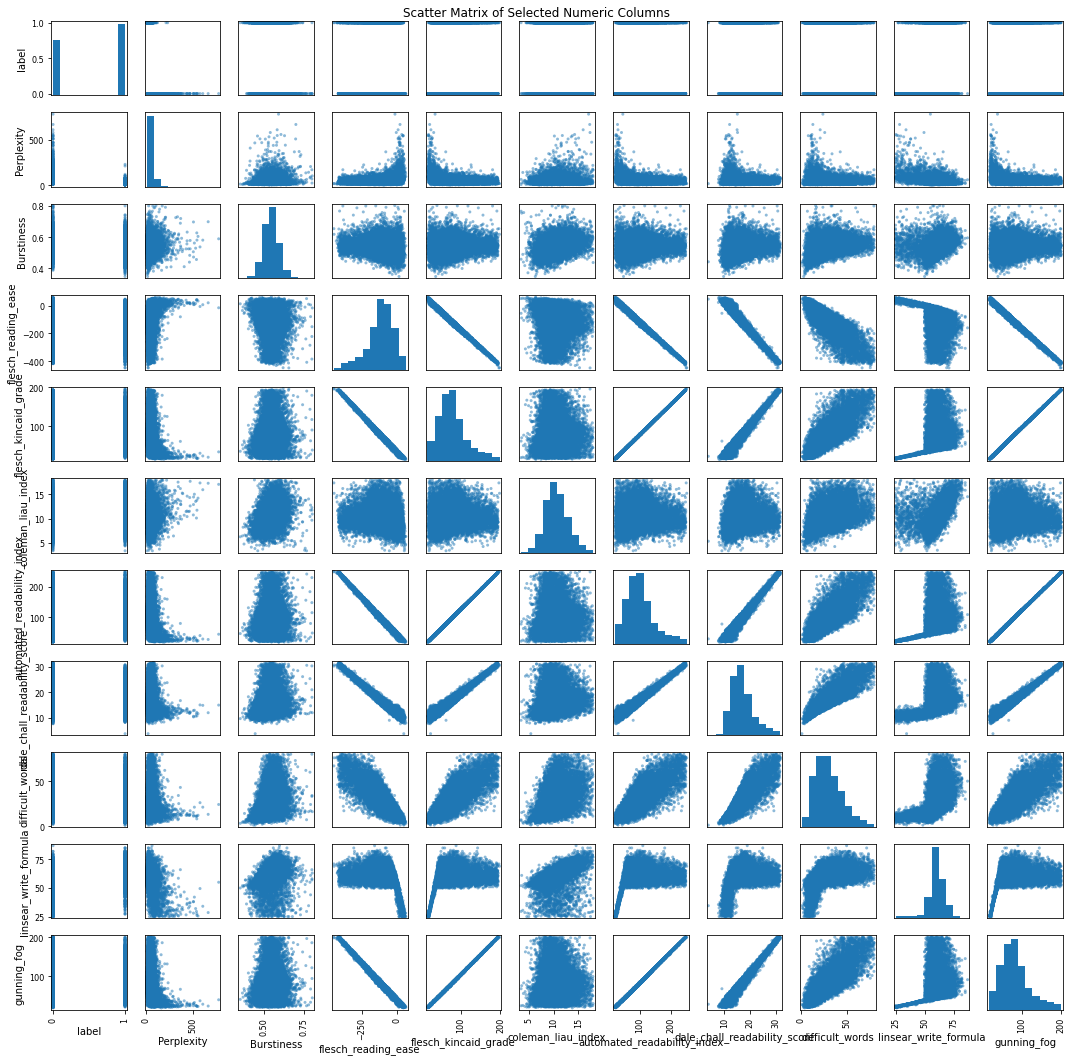

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Assuming cleaned_df is your DataFrame
# Calculate the correlation matrix
numeric_columns = cleaned_df.select_dtypes(include=[float, int]).columns
correlation_matrix = cleaned_df[numeric_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix["label"].sort_values(ascending=False))

# Create scatter plot matrix with histograms on the diagonal
scatter_columns = ['label', 'Perplexity', 'Burstiness', 'flesch_reading_ease',
                   'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index',
                   'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog']

scatter_matrix_plot = scatter_matrix(cleaned_df[scatter_columns], figsize=(15, 15), diagonal='hist')

plt.suptitle('Scatter Matrix of Selected Numeric Columns')
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

As per correlation, I am keepting only top co-related values
 - label                           1.000000
- linsear_write_formula           0.301499
- coleman_liau_index              0.266148
- dale_chall_readability_score   -0.209213
- Perplexity                     -0.597042

In [30]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12971 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   prompt_id                     12971 non-null  object 
 1   gen_text                      12971 non-null  object 
 2   label                         12971 non-null  int64  
 3   text                          12971 non-null  object 
 4   Perplexity                    12971 non-null  float64
 5   Burstiness                    12971 non-null  float64
 6   flesch_reading_ease           12971 non-null  float64
 7   flesch_kincaid_grade          12971 non-null  float64
 8   coleman_liau_index            12971 non-null  float64
 9   automated_readability_index   12971 non-null  float64
 10  dale_chall_readability_score  12971 non-null  float64
 11  difficult_words               12971 non-null  float64
 12  linsear_write_formula         12971 non-null  float64
 13  g

In [31]:
top_corr_columns = ['label', 'prompt_id', 'text', 'linsear_write_formula', 'coleman_liau_index', 'dale_chall_readability_score', 'Perplexity']

top_corr_features_df = cleaned_df[top_corr_columns]

# **Adding Word2Vec features**

In [32]:
import gdown
word2vec_url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
word2vec_output = 'word2vec.bin.gz'
gdown.download(word2vec_url, word2vec_output, quiet=False)
!gunzip word2vec_output

Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=ff605e57-084d-44d2-866b-9bd43217cc71
To: /home/patel.anuj2/Text_detection/word2vec.bin.gz
100%|██████████| 1.65G/1.65G [00:23<00:00, 70.0MB/s]


gzip: word2vec_output.gz: No such file or directory


In [33]:
from gensim import models
#importing Word2Vec
word2vecModel = models.KeyedVectors.load_word2vec_format('word2vec.bin.gz', binary=True)

In [34]:
from gensim.models import KeyedVectors

# Function to create feature matrix for Word2Vec
def text_to_vector(text, model, vector_size=300):
    words = text.split()
    vector = np.zeros((vector_size,))
    count = 0
    for word in words:
        try:
            vector += model[word]
            count += 1
        except KeyError:
            continue
    if count != 0:
        vector /= count
    return vector

def create_feature_matrix(df, text_column, model, vector_size=300):
    feature_matrix = np.empty((len(df), vector_size))
    for i, text in enumerate(df[text_column]):
        feature_matrix[i] = text_to_vector(text, model, vector_size)
    return feature_matrix

# Create Word2Vec feature matrix
word2vec_features = create_feature_matrix(top_corr_features_df, 'text', word2vecModel)


## **Scaling (-1to1)**

$$
\text{scaled\_row} = \left( \frac{\text{row} - \text{min\_vals}}{\text{max\_vals} - \text{min\_vals}} \right) \times (\text{feature\_range}[1] - \text{feature\_range}[0]) + \text{feature\_range}[0]
$$


In [35]:
def min_max_scale(row, min_vals, max_vals, feature_range=(-1, 1)):
    # Manually apply Min-Max scaling
    scaled_row = (row - min_vals) / (max_vals - min_vals) * (feature_range[1] - feature_range[0]) + feature_range[0]
    return scaled_row

In [36]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['linsear_write_formula', 'coleman_liau_index', 'dale_chall_readability_score', 'Perplexity']

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the specified columns
scaled_columns = scaler.fit_transform(top_corr_features_df[columns_to_scale])
word2vec_features_scaled = scaler.fit_transform(word2vec_features)
combined_features = np.hstack((word2vec_features_scaled, scaled_columns))
combined_df = pd.DataFrame(combined_features, columns=[f'word2vec_{i}' for i in range(word2vec_features_scaled.shape[1])] + columns_to_scale)

combined_df.head()

,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,...,word2vec_294,word2vec_295,word2vec_296,word2vec_297,word2vec_298,word2vec_299,linsear_write_formula,coleman_liau_index,dale_chall_readability_score,Perplexity
0,-0.075367,0.073085,-0.148113,-0.023646,0.081067,0.371153,-0.091422,-0.015569,-0.069222,0.356476,...,-0.045598,0.085786,0.173146,0.241230,-0.025400,-0.175763,-0.032258,-0.152011,0.545487,-0.897809
1,0.140317,0.013617,-0.274245,0.093158,-0.075864,0.310177,0.391588,0.209071,0.047189,0.134090,...,-0.159313,0.022618,0.228758,0.041031,-0.026544,-0.160445,0.096774,-0.160191,0.270766,-0.879399
2,-0.003275,0.303299,-0.273109,0.036004,-0.435870,0.275278,0.018487,0.119786,-0.286889,0.027914,...,-0.043513,0.319171,-0.435765,0.086680,0.149783,0.183502,0.064516,0.187457,0.238403,-0.883669
3,0.180891,0.015047,-0.256930,0.136185,0.021145,0.198804,-0.084777,0.265227,-0.070562,0.029377,...,-0.104347,-0.182984,0.157155,-0.249720,-0.230493,-0.122157,-0.096774,-0.374233,0.784969,-0.872891
4,0.220863,-0.048003,-0.181443,0.282664,-0.258546,0.153436,0.199853,0.193024,-0.217520,0.191462,...,-0.144954,-0.404559,0.065131,0.150484,-0.575235,0.408982,-0.645161,-0.082481,-0.517440,-0.567399


In [37]:
columns_to_scale = ['linsear_write_formula', 'coleman_liau_index', 'dale_chall_readability_score', 'Perplexity']

only_corr_df = top_corr_features_df[columns_to_scale].values
combined_features_unscaled = np.hstack((word2vec_features, only_corr_df))
combined_df_unsc = pd.DataFrame(combined_features_unscaled, columns=[f'word2vec_{i}' for i in range(word2vec_features.shape[1])] + columns_to_scale)

#to be used in inferencing part
min_array = combined_df_unsc.min().values
max_array = combined_df_unsc.max().values

combined_features_scaled = min_max_scale(combined_df_unsc, min_array, max_array)

combined_features_scaled.head()

,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,...,word2vec_294,word2vec_295,word2vec_296,word2vec_297,word2vec_298,word2vec_299,linsear_write_formula,coleman_liau_index,dale_chall_readability_score,Perplexity
0,-0.075367,0.073085,-0.148113,-0.023646,0.081067,0.371153,-0.091422,-0.015569,-0.069222,0.356476,...,-0.045598,0.085786,0.173146,0.241230,-0.025400,-0.175763,-0.032258,-0.152011,0.545487,-0.897809
1,0.140317,0.013617,-0.274245,0.093158,-0.075864,0.310177,0.391588,0.209071,0.047189,0.134090,...,-0.159313,0.022618,0.228758,0.041031,-0.026544,-0.160445,0.096774,-0.160191,0.270766,-0.879399
2,-0.003275,0.303299,-0.273109,0.036004,-0.435870,0.275278,0.018487,0.119786,-0.286889,0.027914,...,-0.043513,0.319171,-0.435765,0.086680,0.149783,0.183502,0.064516,0.187457,0.238403,-0.883669
3,0.180891,0.015047,-0.256930,0.136185,0.021145,0.198804,-0.084777,0.265227,-0.070562,0.029377,...,-0.104347,-0.182984,0.157155,-0.249720,-0.230493,-0.122157,-0.096774,-0.374233,0.784969,-0.872891
4,0.220863,-0.048003,-0.181443,0.282664,-0.258546,0.153436,0.199853,0.193024,-0.217520,0.191462,...,-0.144954,-0.404559,0.065131,0.150484,-0.575235,0.408982,-0.645161,-0.082481,-0.517440,-0.567399


# **Train-Test Split**

In [38]:
# Prepare data for logistic regression
#X = combined_df
X = combined_features_scaled
y = cleaned_df['label']  # Assuming 'label' is the target column in your dataset

In [39]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Classical Machine Learning**

### **Import necessary libraries**


In [40]:
# Import necessary libraries for various machine learning tasks

# Time measurement and joblib for saving and loading models
import time  # To measure the time taken for operations
import joblib  # For saving and loading models

# Numerical and data manipulation libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis

# Machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models

# Model evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Basic evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score  # Advanced evaluation metrics

# Model selection and hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Hyperparameter tuning
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold  # Model validation

# Visualization libraries
import seaborn as sns  # For creating heatmaps and visualizations
import matplotlib.pyplot as plt  # For creating plots and visualizations

# Sparse matrices
from scipy.sparse import hstack  # For horizontally stacking sparse matrices

# **Logistic Regression**

---



## **Training the Logistic Regression**

In [41]:
# Start timing the process
start_time = time.time()

# Standard Logistic Regression
model = LogisticRegression(max_iter=200)

# Fit the model on the training data
model.fit(X_train, y_train)

# Save the standard logistic regression model
joblib.dump(model, 'standard_logistic_regression.pkl')

# Print all parameter values of the model
print("Model parameters:\n", model.get_params())

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print("Standard Logistic Regression Accuracy:", accuracy)
print("Standard Logistic Regression Classification Report:\n", report)

# Print the time taken
print("Time taken for Standard Logistic Regression: {:.2f} seconds".format(time.time() - start_time))

Model parameters:
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Standard Logistic Regression Accuracy: 0.9591522157996146
Standard Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1152
           1       0.96      0.97      0.96      1443

    accuracy                           0.96      2595
   macro avg       0.96      0.96      0.96      2595
weighted avg       0.96      0.96      0.96      2595

Time taken for Standard Logistic Regression: 0.21 seconds


### **Plot of Confusion Matrix**

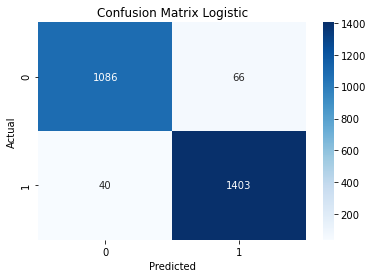

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Logistic')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve and AUC**

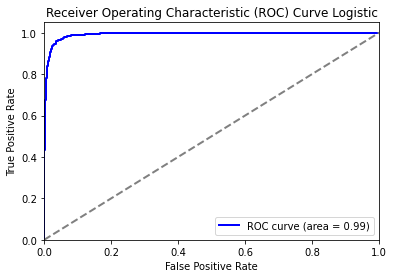

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the Area Under the ROC Curve (AUC) to summarize the model's performance
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Logistic')
plt.legend(loc="lower right")
plt.show()

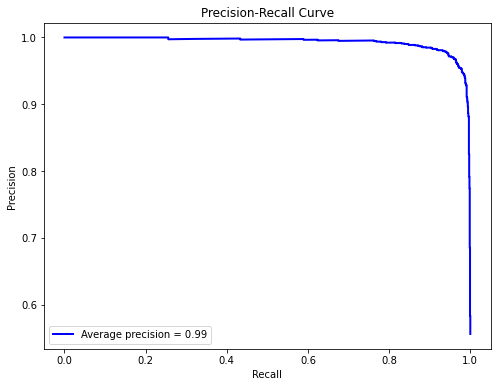

In [46]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [47]:
# Cross-Validation Scores
cv_scores = cross_val_score(model, X_train, y_train, cv=5) # Change
print(f'Cross-validated accuracy scores: {cv_scores}')
print(f'Mean cross-validated accuracy: {cv_scores.mean():.2f}')
print(f'Standard deviation of cross-validated accuracy: {cv_scores.std():.2f}')

Cross-validated accuracy scores: [0.95086705 0.95855422 0.96144578 0.96       0.96915663]
Mean cross-validated accuracy: 0.96
Standard deviation of cross-validated accuracy: 0.01


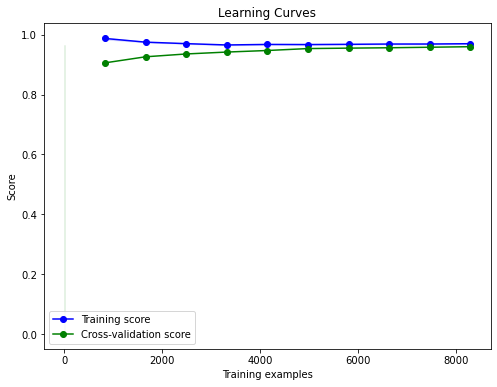

In [48]:
# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

## **Logistic Regression (Grid Search)**

### **Training the Logistic Regression Model with GridSearch**


In [82]:
import time
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Start timer
start_time = time.time()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 300],
     'class_weight': [None, 'balanced'], 'tol': [1e-4, 1e-3, 1e-2], 'fit_intercept': [True, False]},
    {'solver': ['lbfgs'], 'penalty': ['l2'],
     'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 300],
     'class_weight': [None, 'balanced'], 'tol': [1e-4, 1e-3, 1e-2], 'fit_intercept': [True, False]}
]

# Set up GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=5,  # Increased number of folds for better generalization estimate
    scoring='accuracy',
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'logistic_grid_search.pkl')

# Predict and evaluate the best model
y_pred_best_grid = best_model_grid.predict(X_test_scaled)
accuracy_best_grid = accuracy_score(y_test, y_pred_best_grid)
report_best_grid = classification_report(y_test, y_pred_best_grid)

# Output results
print("Grid Search Logistic Regression Accuracy:", accuracy_best_grid)
print("Grid Search Logistic Regression Classification Report:\n", report_best_grid)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print("Time taken for Grid Search Logistic Regression: {:.2f} seconds".format(elapsed_time))


Grid Search Logistic Regression Accuracy: 0.971868978805395
Grid Search Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1152
           1       0.97      0.98      0.97      1443

    accuracy                           0.97      2595
   macro avg       0.97      0.97      0.97      2595
weighted avg       0.97      0.97      0.97      2595

Time taken for Grid Search Logistic Regression: 74.12 seconds


### **Confusion Matrix**

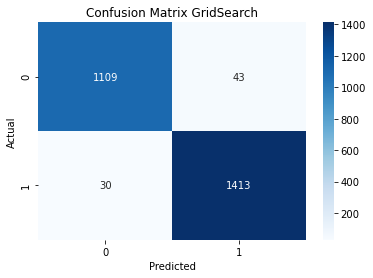

In [89]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_grid)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix GridSearch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve and AUC**

/home/patel.anuj2/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


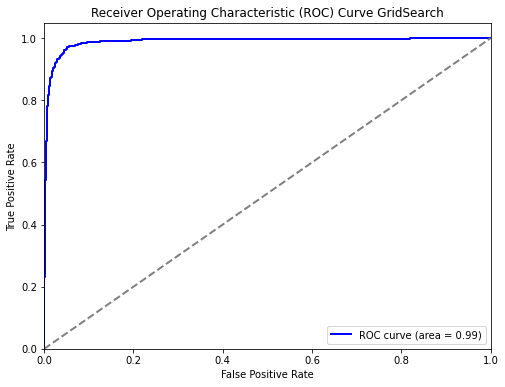

In [93]:
# Calculate the probabilities for the positive class
y_prob = best_model_grid.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the Area Under the ROC Curve (AUC) to summarize the model's performance
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve GridSearch')
plt.legend(loc="lower right")
plt.show()

### **Precision-Recall Curve**

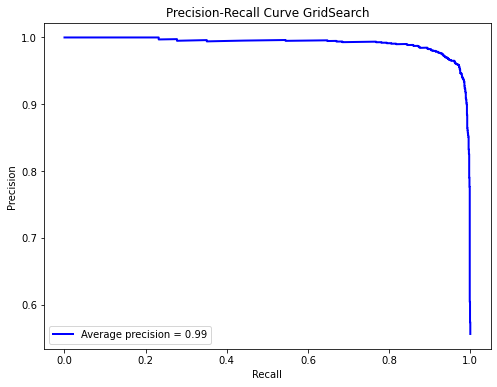

In [94]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve GridSearch')
plt.legend(loc="lower left")
plt.show()

### **Cross-Validation Scores**

In [95]:
# Cross-Validation Scores
cv_scores = cross_val_score(best_model_grid, X_train, y_train, cv=5) # Change
print(f'Cross-validated accuracy scores: {cv_scores}')
print(f'Mean cross-validated accuracy: {cv_scores.mean():.2f}')
print(f'Standard deviation of cross-validated accuracy: {cv_scores.std():.2f}')

Cross-validated accuracy scores: [0.90510597 0.91855422 0.91807229 0.91710843 0.9253012 ]
Mean cross-validated accuracy: 0.92
Standard deviation of cross-validated accuracy: 0.01


### **Learning Curves**

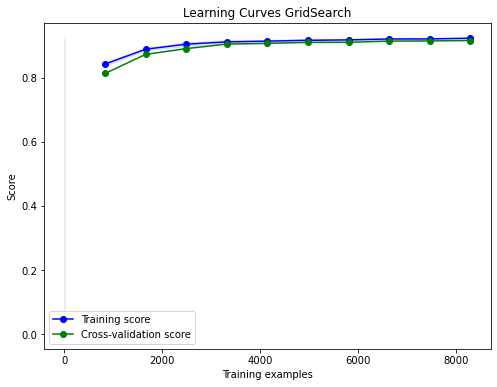

In [96]:
# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model_grid, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves GridSearch')
plt.legend(loc='best')
plt.show()

## **Logistic Regression (RandomSearch)**

### **Training the Logistic Regression Model with Randomized Search**

In [81]:
import time
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Time the randomized search logistic regression model
start_time = time.time()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter distribution with compatible solver and penalty
param_dist = {
    'max_iter': [100, 200, 300],
    'C': uniform(0.01, 100),  # Uniform distribution over [0.01, 100.01)
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],  # Start with l2, which is compatible with both solvers
    'class_weight': [None, 'balanced'],
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'fit_intercept': [True, False]  # Whether to include an intercept
}

# Add l1 penalties only for compatible solvers
param_dist_liblinear = param_dist.copy()
param_dist_liblinear['penalty'] = ['l1', 'l2']
param_dist_liblinear['solver'] = ['liblinear']

# Combine parameter distributions
param_distributions = [param_dist, param_dist_liblinear]

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_distributions,
    n_iter=25,
    cv=StratifiedKFold(n_splits=3),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit the model with random search on the scaled training data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters from Randomized Search:", best_params)

# Train the model with the best parameters on the scaled training data
best_model_random = LogisticRegression(**best_params)
best_model_random.fit(X_train_scaled, y_train)

# Save the best model from Randomized Search
joblib.dump(best_model_random, 'logistic_random_search.pkl')

# Predict on the test data with the best model
y_pred_best_random = best_model_random.predict(X_test_scaled)

# Evaluate the best model
accuracy_best_random = accuracy_score(y_test, y_pred_best_random)
report_best_random = classification_report(y_test, y_pred_best_random)

# Output the results
print("Random Search Logistic Regression Accuracy:", accuracy_best_random)
print("Random Search Logistic Regression Classification Report:\n", report_best_random)

# Print the time taken
print("Time taken for Randomized Search Logistic Regression: {:.2f} seconds".format(time.time() - start_time))


Best parameters from Randomized Search: {'C': 23.608491974895575, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Random Search Logistic Regression Accuracy: 0.9703275529865125
Random Search Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1152
           1       0.98      0.97      0.97      1443

    accuracy                           0.97      2595
   macro avg       0.97      0.97      0.97      2595
weighted avg       0.97      0.97      0.97      2595

Time taken for Randomized Search Logistic Regression: 4.00 seconds


### **Confusion Matrix**

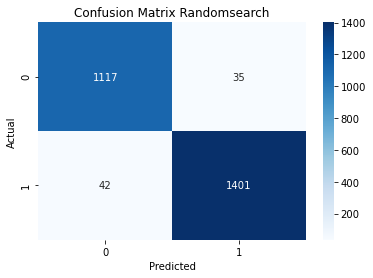

In [88]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best_random)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Randomsearch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve and AUC**

/home/patel.anuj2/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


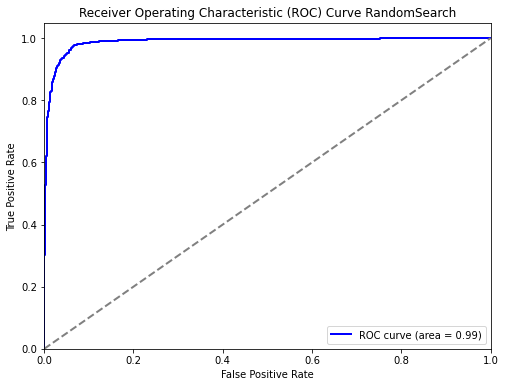

In [98]:
# Calculate the probabilities for the positive class
y_prob = best_model_random.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the Area Under the ROC Curve (AUC) to summarize the model's performance
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve RandomSearch')
plt.legend(loc="lower right")
plt.show()


### **Precision-Recall Curve**

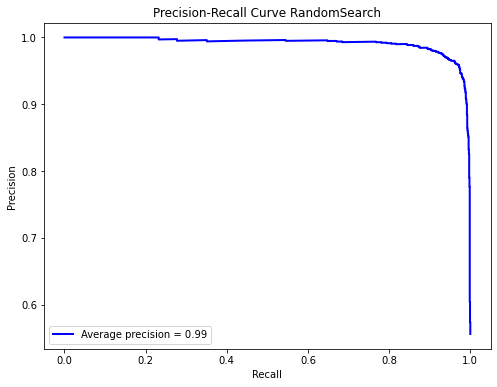

In [97]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve RandomSearch')
plt.legend(loc="lower left")
plt.show()

### **Cross-Validation Scores**

In [76]:
# Cross-Validation Scores
cv_scores = cross_val_score(best_model_random, X_train, y_train, cv=5)
print(f'Cross-validated accuracy scores: {cv_scores}')
print(f'Mean cross-validated accuracy: {cv_scores.mean():.2f}')
print(f'Standard deviation of cross-validated accuracy: {cv_scores.std():.2f}')

Cross-validated accuracy scores: [0.96579961 0.97108434 0.9653012  0.97204819 0.97831325]
Mean cross-validated accuracy: 0.97
Standard deviation of cross-validated accuracy: 0.00


### **Learning Curves**

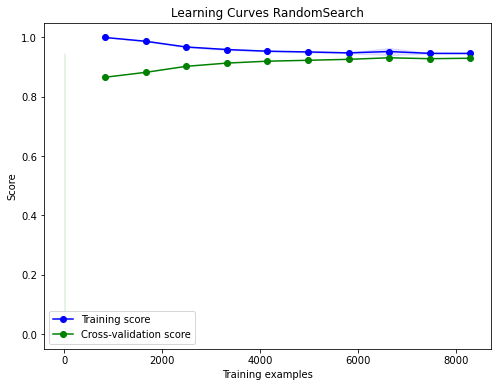

In [99]:
# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model_random, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves RandomSearch')
plt.legend(loc='best')
plt.show()

# **Support Vector Machines(SVM)**

---



## **Training the SVM Model**


In [103]:
# Time and save the standard SVM model
start_time = time.time()

# Initialize the SVM model with default parameters
# Comment: Initialize the Support Vector Classifier (SVC) with default parameters.
model_svm = SVC(probability=True)  # Set probability=True to enable probability estimates

print("Default parameters of the SVM model:", model_svm.get_params())

# Fit the model on the training data
# Comment: Train the SVM model using the combined training features and labels.
model_svm.fit(X_train, y_train)

# Save the trained SVM model
# Comment: Save the trained SVM model to a file for later use.
joblib.dump(model_svm, 'standard_svm_model.pkl')

# Predict on the test data
# Comment: Use the trained SVM model to make predictions on the test data.
y_pred = model_svm.predict(X_test)

# Evaluate the model
# Comment: Calculate the accuracy of the SVM model on the test data.
accuracy_svm = accuracy_score(y_test, y_pred)
# Comment: Generate a classification report which includes precision, recall, and F1-score.
report_svm = classification_report(y_test, y_pred)

# Output the results
# Comment: Print the accuracy of the SVM model.
print("Standard SVM Accuracy:", accuracy_svm)
# Comment: Print the detailed classification report of the SVM model.
print("Standard SVM Classification Report:\n", report_svm)

# Print the time taken
# Comment: Print the time taken to train and evaluate the SVM model.
print("Time taken for Standard SVM: {:.2f} seconds".format(time.time() - start_time))

Default parameters of the SVM model: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Standard SVM Accuracy: 0.9576107899807321
Standard SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1152
           1       0.95      0.98      0.96      1443

    accuracy                           0.96      2595
   macro avg       0.96      0.95      0.96      2595
weighted avg       0.96      0.96      0.96      2595

Time taken for Standard SVM: 37.02 seconds


### **Confusion Matrix**

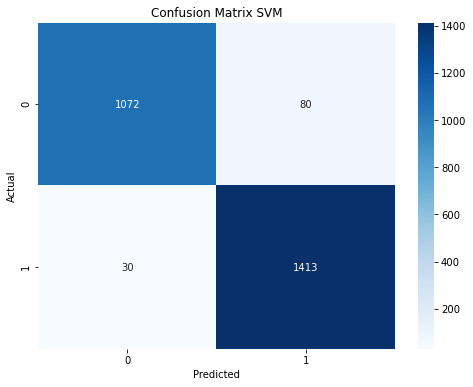

In [87]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **ROC Curve and AUC**

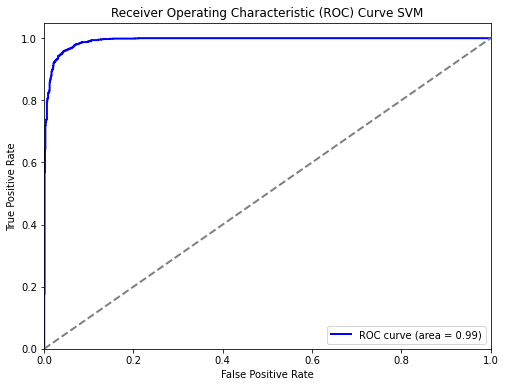

In [100]:
# Calculate the probabilities for the positive class
y_prob = model_svm.predict_proba(X_test)[:, 1]

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the Area Under the ROC Curve (AUC) to summarize the model's performance
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve SVM')
plt.legend(loc="lower right")
plt.show()

### **Precision-Recall Curve**

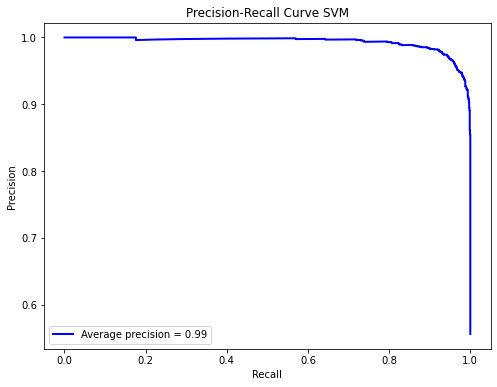

In [101]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVM')
plt.legend(loc="lower left")
plt.show()

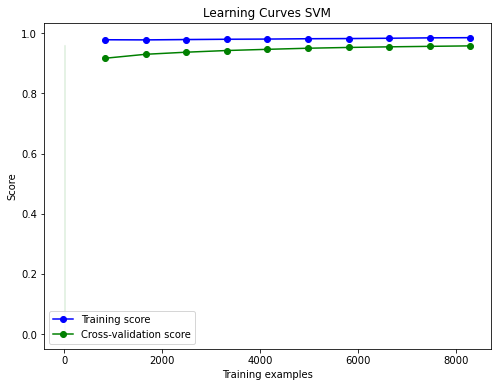

In [102]:
# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    model_svm, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves SVM')
plt.legend(loc='best')
plt.show()

# **Deep Learning ML**